In [140]:
import os
from PIL import Image

import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
from trainers import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

# https://www.kaggle.com/prasunroy/natural-images
data_dir = "../testing/data/natural_images/"

CLASSES, files = map_images(data_dir)
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]


In [3]:
def train(model, toy=False):
        """
        Train the model
        """
        if toy:
            epochs=3
            steps_per_epoch=20
            validation_steps=2
        else:
            epochs=30
#             steps_per_epoch=100
            steps_per_epoch=30
#             steps_per_epoch=10
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_acc'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit(x_train, y_train
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=(x_val, y_val)
                                ,validation_steps=validation_steps
                                ,callbacks=[earlystopper, checkpointer, reduce_lr], verbose=3)
        # Get the best saved weights
        model.load_weights('best_model1.h5')
        return training

In [4]:
ROUNDS = 32 # after about 30-40, it seems to settle down with epochs being 16
EPOCHS = 16
MAJORITY_SPLIT = 0.7

In [5]:
# forces tensorfor to the a particular device to run things
#      # return a dictionary of users with data
users_all = init_users_image(files, averaging_methods, majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_all, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.all,
          averaging_post = True,
          averaging_metric = "accuracy")



********************************  0   ********************************
0 [9.774694760640463, 0.040650405]
1 [7.04132578290742, 0.06896552]
2 [18.982430458068848, 0.0390625]
3 [11.439511427642605, 0.021276595]
4 [5.988216416877613, 0.22807017]
5 [3.9954597552617392, 0.4375]
6 [13.931021997145006, 0.027972028]
7 [8.573457371104848, 0.06818182]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.021578860476734, 0.35772356]
1 [2.061411446538465, 0.13793103]
2 [2.0906654000282288, 0.078125]
3 [2.07301900910993, 0.08510638]
4 [2.0404756194666813, 0.22807017]
5 [2.104408476087782, 0.07638889]
6 [2.0219048370014536, 0.6993007]
7 [2.057046586816961, 0.13636364]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.813188057604844, 0.7479675]
1 [1.2846781303142678, 0.49137932]
2 [1.7710237503051758, 0.2578125]

All
For central
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.878611
Standard Deviation    0.0831908
Minimum                0.736842
Maximum                 0.95935
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.926002
Standard Deviation    0.0380441
Minimum                0.842105
Maximum                0.965278
Name: 63, dtype: object



/home/kts1/proj/src/graphing.py:316: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(os.path.join(path,f'{save_as}-{metric}-pre.csv'))
/home/kts1/proj/src/graphing.py:332: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  finals.to_csv(os.path.join(path,f'{save_as}-{metric}-post.csv'))


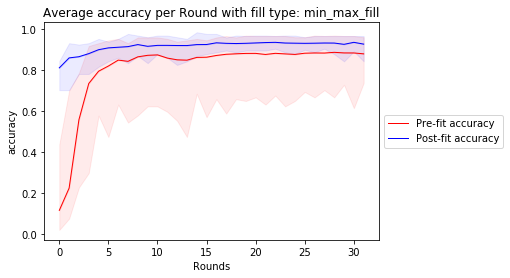

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.959350
3     1     0.913793
5     2     0.843750
7     3     0.936170
9     4     0.736842
11    5     0.958333
13    6     0.923077
15    7     0.757576
Averaged: 0.878611370921135

Final accuracy for Post-fit data
   User  Final Value
0     0     0.959350
2     1     0.931035
4     2     0.890625
6     3     0.936170
8     4     0.842105
10    5     0.965278
12    6     0.944056
14    7     0.939394
Averaged: 0.926001526415348



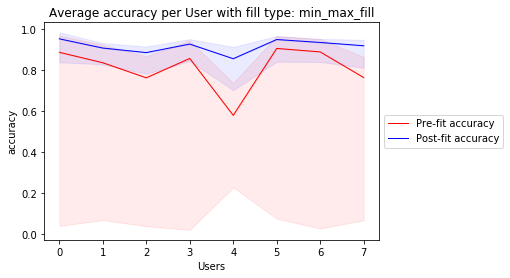

<Figure size 432x288 with 0 Axes>

In [32]:
ignore_first_n = 0
final_values = True

GRAPHING_METRIC = "accuracy"


print("All")

print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"centralround-{MAJORITY_SPLIT}",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"centraluser-{MAJORITY_SPLIT}",
                                       final_values = final_values)

In [7]:
averaging_methods = [Average.std_dev]
# return a dictionary of users with data
users_std_dev = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_std_dev, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method =  Average.std_dev,
         averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_std_dev_p2p = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_std_dev_p2p, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")



********************************  0   ********************************
0 [9.774694760640463, 0.040650405]
1 [7.04132578290742, 0.06896552]
2 [18.982430458068848, 0.0390625]
3 [11.439511427642605, 0.021276595]
4 [5.988216416877613, 0.22807017]
5 [3.9954597552617392, 0.4375]
6 [13.931021997145006, 0.027972028]
7 [8.573457371104848, 0.06818182]
User 4: 0.6929824352264404 < 0.7607154495715353
******************************** DONE ********************************
********************************  1   ********************************
0 [1.977238668658869, 0.4715447]
1 [2.037178968561107, 0.44827586]
2 [2.0874115228652954, 0.0859375]
3 [2.085980185380219, 0.09219858]
4 [2.0662597564228795, 0.12280702]
5 [2.1172163486480713, 0.11805555]
6 [2.025136357420808, 0.7202797]
7 [2.061727184237856, 0.13636364]
User 4: 0.7368420958518982 < 0.798273406952922
******************************** DONE ********************************
********************************  2   ********************************
0 [0.

Std deviation
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average                0.86195
Standard Deviation    0.158249
Minimum               0.447368
Maximum               0.958333
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                  Post
Round                       31
Average               0.929028
Standard Deviation    0.029397
Minimum               0.868421
Maximum               0.972222
Name: 63, dtype: object



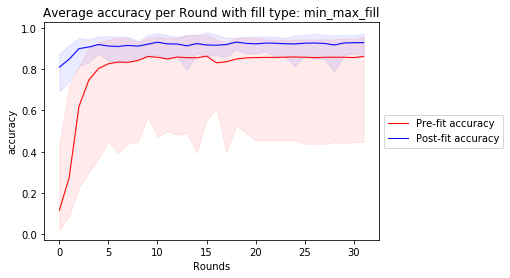

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.926829
3     1     0.905172
5     2     0.890625
7     3     0.943262
9     4     0.447368
11    5     0.958333
13    6     0.930070
15    7     0.893939
Averaged: 0.8619500137865543

Final accuracy for Post-fit data
   User  Final Value
0     0     0.934959
2     1     0.931035
4     2     0.906250
6     3     0.957447
8     4     0.868421
10    5     0.972222
12    6     0.930070
14    7     0.931818
Averaged: 0.929027758538723



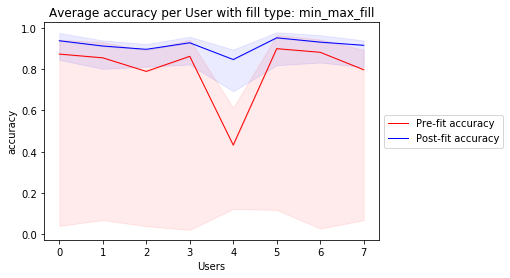

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.873163
Standard Deviation    0.129717
Minimum                0.54386
Maximum               0.965278
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.933185
Standard Deviation    0.0271361
Minimum                0.877193
Maximum                 0.95935
Name: 63, dtype: object



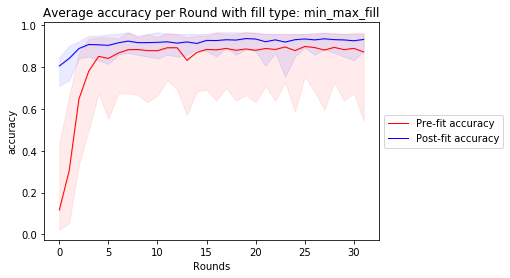

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.943089
3     1     0.922414
5     2     0.867188
7     3     0.950355
9     4     0.543860
11    5     0.965278
13    6     0.937063
15    7     0.856061
Averaged: 0.8731632903218269

Final accuracy for Post-fit data
   User  Final Value
0     0     0.959350
2     1     0.931035
4     2     0.906250
6     3     0.957447
8     4     0.877193
10    5     0.958333
12    6     0.944056
14    7     0.931818
Averaged: 0.9331851601600647



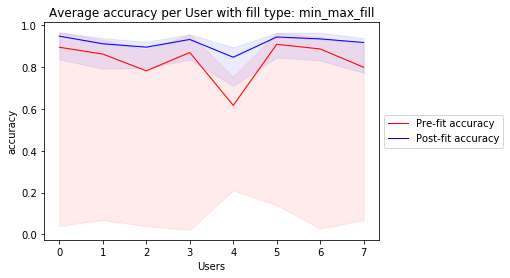

<Figure size 432x288 with 0 Axes>

In [25]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Std deviation")
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"stdround-{MAJORITY_SPLIT}",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"stduser-{MAJORITY_SPLIT}",
                                       final_values = final_values)
print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_p2p, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"stdround_p2p-{MAJORITY_SPLIT}",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_p2p, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"stduser_p2p-{MAJORITY_SPLIT}",
                                       final_values = final_values)


# print(users_std_dev[1].get_history_metrics())


In [9]:
averaging_methods = [Average.weighted_avg]

# return a dictionary of users with data
users_weighted_avg = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_weighted_avg, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.weighted_avg,
          averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_weighted_avg_p2p = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_weighted_avg_p2p, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")

********************************  0   ********************************
0 [9.774694760640463, 0.040650405]
1 [7.04132578290742, 0.06896552]
2 [18.982430458068848, 0.0390625]
3 [11.439511427642605, 0.021276595]
4 [5.988216416877613, 0.22807017]
5 [3.9954597552617392, 0.4375]
6 [13.931021997145006, 0.027972028]
7 [8.573457371104848, 0.06818182]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.0106924549350893, 0.43089432]
1 [2.0535842139145424, 0.22413793]
2 [2.095595598220825, 0.09375]
3 [2.08152644515883, 0.09929078]
4 [2.048400351875707, 0.23684211]
5 [2.103884696960449, 0.090277776]
6 [2.027081611273172, 0.74125874]
7 [2.060963623451464, 0.15151516]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.6622218484801006, 0.80487806]
1 [1.1748853921890259, 0.6034483]
2 [1.6714722216129303, 0.28125]


Weighted average
For central
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.880791
Standard Deviation    0.0879354
Minimum                0.692982
Maximum                0.951389
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.927283
Standard Deviation    0.0259715
Minimum                0.877193
Maximum                0.957447
Name: 63, dtype: object



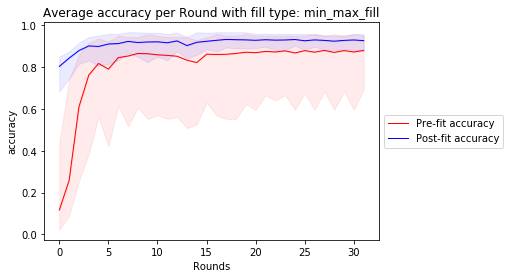

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.934959
3     1     0.939655
5     2     0.851562
7     3     0.943262
9     4     0.692982
11    5     0.951389
13    6     0.937063
15    7     0.795455
Averaged: 0.8807910308241844

Final accuracy for Post-fit data
   User  Final Value
0     0     0.943089
2     1     0.922414
4     2     0.898438
6     3     0.957447
8     4     0.877193
10    5     0.951389
12    6     0.944056
14    7     0.924242
Averaged: 0.9272834658622742



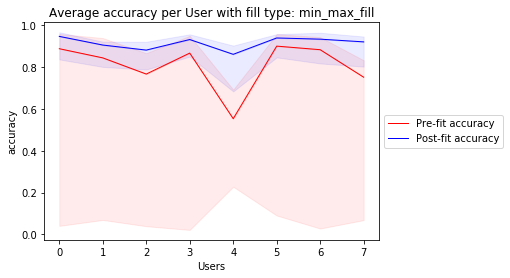

For p2p
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.886795
Standard Deviation    0.0764775
Minimum                0.719298
Maximum                0.965278
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.933023
Standard Deviation    0.0235469
Minimum                0.885965
Maximum                0.958333
Name: 63, dtype: object



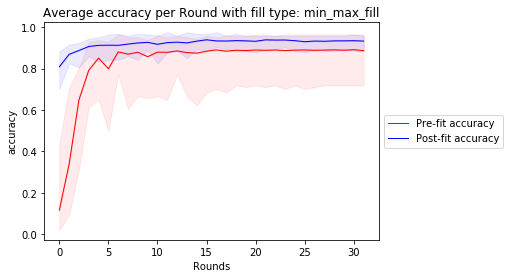

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.943089
3     1     0.922414
5     2     0.859375
7     3     0.929078
9     4     0.719298
11    5     0.965278
13    6     0.930070
15    7     0.825758
Averaged: 0.8867949694395065

Final accuracy for Post-fit data
   User  Final Value
0     0     0.951219
2     1     0.905172
4     2     0.929688
6     3     0.950355
8     4     0.885965
10    5     0.958333
12    6     0.944056
14    7     0.939394
Averaged: 0.9330227673053741



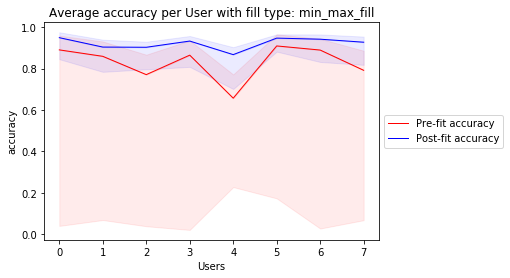

<Figure size 432x288 with 0 Axes>

In [26]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Weighted average")

print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"weightround-{MAJORITY_SPLIT}",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"weightuser-{MAJORITY_SPLIT}",
                                       final_values = final_values)

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_p2p, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"weightround_p2p-{MAJORITY_SPLIT}",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_p2p, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"weightuser_p2p-{MAJORITY_SPLIT}",
                                       final_values = final_values)


In [11]:
users_local_only = init_users_image(files, averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED)
train_fed(users = users_local_only, rounds = ROUNDS,
          epochs = EPOCHS,

          strat = "local_trainings_only",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")
        
#     print("Global user training and validation")

#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = False,
#     )

********************************  0   ********************************
0 [9.774694760640463, 0.040650405]
1 [7.04132578290742, 0.06896552]
2 [18.982430458068848, 0.0390625]
3 [11.439511427642605, 0.021276595]
4 [5.988216416877613, 0.22807017]
5 [3.9954597552617392, 0.4375]
6 [13.931021997145006, 0.027972028]
7 [8.573457371104848, 0.06818182]
******************************** DONE ********************************
********************************  1   ********************************
0 [0.49320784332306405, 0.8292683]
1 [0.5741714362440438, 0.8189655]
2 [0.6693953489884734, 0.796875]
3 [0.46128301163937185, 0.8439716]
4 [1.028928514112506, 0.7017544]
5 [0.530676208022568, 0.8263889]
6 [0.4392445179132315, 0.86013985]
7 [0.6963169967586343, 0.81060606]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.7726229729691172, 0.83739835]
1 [0.5712860123864536, 0.86206895]
2 [0.677268460392952, 0.875]


Local training only
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.877735
Standard Deviation    0.0514121
Minimum                0.763158
Maximum                0.944056
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.876658
Standard Deviation    0.0512773
Minimum                0.763158
Maximum                0.944056
Name: 63, dtype: object



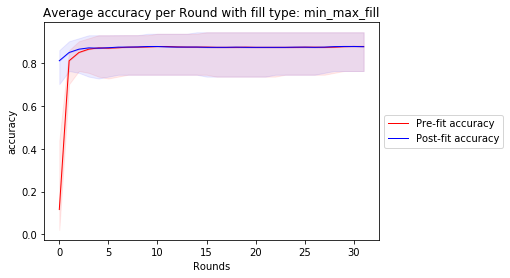

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.894309
3     1     0.887931
5     2     0.851562
7     3     0.893617
9     4     0.763158
11    5     0.923611
13    6     0.944056
15    7     0.863636
Averaged: 0.8777351006865501

Final accuracy for Post-fit data
   User  Final Value
0     0     0.894309
2     1     0.879310
4     2     0.851562
6     3     0.893617
8     4     0.763158
10    5     0.923611
12    6     0.944056
14    7     0.863636
Averaged: 0.8766575157642365



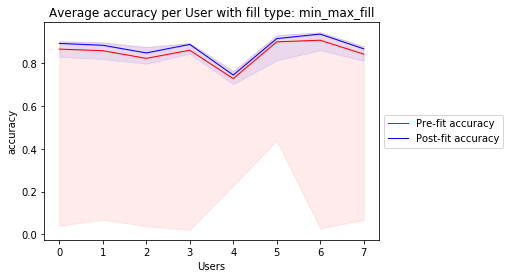

<Figure size 432x288 with 0 Axes>

In [27]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"


print("Local training only")


df_avg_round_stats_acc = avg_round_stats(users_local_only, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC, save_as = f"localround-{MAJORITY_SPLIT}",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_local_only, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC, save_as = f"localuser-{MAJORITY_SPLIT}",
                                       final_values = final_values)
# draw_graphs(users_all_p2p[2])

# print("Global user")
# draw_graphs(global_user)
# global_user.evaluate(verbose=False)

for user in users.keys():
    draw_grapdhs(user)

In [14]:
global_user = init_users_image(files,averaging_methods,majority_split = MAJORITY_SPLIT, seed = SEED, return_global_user=True)
print(global_user.get_train_data().dtype)
global_user.get_model().summary()
global_user.train(
    epochs = ROUNDS*EPOCHS,
    verbose_fit = False,
    verbose_evaluate = False
)

uint8
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_280 (Conv2D)          (None, 78, 78, 32)        896       
_________________________________________________________________
conv2d_281 (Conv2D)          (None, 76, 76, 64)        18496     
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_282 (Conv2D)          (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_283 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 8, 8, 128) 

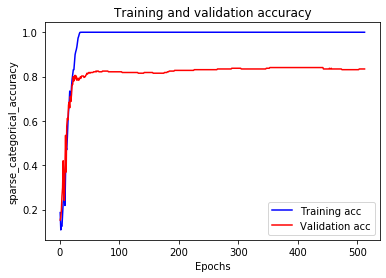

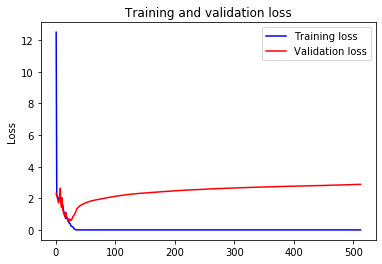

<Figure size 432x288 with 0 Axes>

In [29]:
draw_graphs(global_user, save_as=f"global_{MAJORITY_SPLIT}")

In [31]:
with open(f"../out/{GRAPHING_METRIC}-{MAJORITY_SPLIT}.csv", "w") as out:
    strats = [users_local_only, users_all, users_std_dev, users_std_dev_p2p, users_weighted_avg, users_weighted_avg_p2p]
    strats_names = ["Local only", "All (traditional)", "Std dev Central", "Std dev P2P", "Weighted avg Central", "Weighted avg P2P"]
    g_weights = global_user.get_weights()
    out.write("Testing user models (post fit) on global model aggregate data,\n")
    e = global_user.evaluate(verbose=False)
    out.write(f"{GRAPHING_METRIC}-globaluser,{e[0]},{e[1]},\n")
#     print(global_user.evaluate(verbose=False))
    
    for i, strat in enumerate(strats):
#         print(strats_names[i])
        out.write(strats_names[i]+",\n")
        for user in strat.values():
            global_user.set_weights(user.get_weights())
            e = global_user.evaluate(verbose=False)
            out.write(f"{GRAPHING_METRIC}-user-{user.get_id()}:,{e[0]},{e[1]},\n")
#             print(f"{GRAPHING_METRIC}-{user.get_id()}: {e}")


# user = users_local_only[4]
for i, user in enumerate(users_all.values()):
    print(f"{GRAPHING_METRIC}-{CLASSES[i]:<10} -> {user.get_id()}: {np.unique(user.get_train_class(), return_counts=True)}")
    
print(f"{GRAPHING_METRIC}-{' ':<10} -> {global_user.get_id()}: {np.unique(global_user.get_train_class(), return_counts=True)}")
print(f"{GRAPHING_METRIC}-{' ':<10} -> {global_user.get_id()}: {np.unique(global_user.get_test_class(), return_counts=True)}")
print(f"{GRAPHING_METRIC}-{' ':<10} -> {global_user.get_id()}: {np.unique(global_user.get_val_class(), return_counts=True)}")

# print(np.equal(users_all[1].get_test_class(),users_weighted_avg[1].get_test_class()).all())